### Setup environment

In [ ]:

!pip install mediapy einops --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.1 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torch
import mediapy as media
import torch.optim as optim


### Implementing building blocks for u-net

In [ ]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding=1)
        self.norm = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.norm(x)
        x = self.gelu(x)
        return x

class FinalConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        return x

class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 2, padding=1)
        self.norm = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.norm(x)
        x = self.gelu(x)
        return x

class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.convTrans = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1)
        self.norm = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.convTrans(x)
        x = self.norm(x)
        x = self.gelu(x)
        return x


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.AvgPool2d(kernel_size = 7, stride = 7)
        self.gelu = nn.GELU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        x = self.gelu(x)
        return x


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.unflatten = nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 7, stride = 7, padding = 0)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.unflatten(x)
        x = self.gelu(x)
        return x


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding=1)
        self.norm = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.BatchNorm2d(out_channels)
        self.gelu2 = nn.GELU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.norm(x)
        x = self.gelu(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.gelu2(x)
        return x


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.downConv = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 2, padding=1)
        self.norm = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()
        self.conv = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding=1)
        self.norm2 = nn.BatchNorm2d(out_channels)
        self.gelu2 = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.downConv(x)
        x = self.norm(x)
        x = self.gelu(x)
        x = self.conv(x)
        x = self.norm2(x)
        x = self.gelu2(x)
        return x


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.upConv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1)
        self.norm = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()
        self.conv = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding=1)
        self.norm2 = nn.BatchNorm2d(out_channels)
        self.gelu2 = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.upConv(x)
        x = self.norm(x)
        x = self.gelu(x)
        x = self.conv(x)
        x = self.norm2(x)
        x = self.gelu2(x)
        return x

class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.fc1_t = nn.Linear(in_channels, out_channels)
        self.gelu = nn.GELU()
        self.fc2_t = nn.Linear(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1_t(x)
        x = self.gelu(x)
        x = self.fc2_t(x)
        return x

### Gathering and ordering data

In [ ]:
train_dataset = MNIST(root='./data', train=True, transform=ToTensor(), download=True)
test_dataset = MNIST(root='./data', train=False, transform=ToTensor(), download=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 42.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.16MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.3MB/s]


In [ ]:
def noisingImage(img: torch.Tensor, noise_std: float) -> torch.Tensor:
    noisy_img = img + torch.randn_like(img) * noise_std
    noisy_img = (noisy_img - noisy_img.min()) / (noisy_img.max() - noisy_img.min())
    return noisy_img


In [ ]:
#dataset wrapper for adding noise to a whole dataset.
class PairedNoisyMNIST(Dataset):
    def __init__(self, original_dataset, noise_std):
        self.original_dataset = original_dataset
        self.noise_std = noise_std

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        img, label = self.original_dataset[idx]
        noisy_img = noisingImage(img, self.noise_std)
        return img, noisy_img, label

### Loading the discriminator

In [ ]:
import torch
def prepare_batch_discr(batch: torch.Tensor) -> torch.Tensor:
    assert isinstance(batch, torch.Tensor) and batch.ndim == 4, "Input must be [N,C,H,W] tensor"
    batch = batch.clamp(0.0, 1.0)
    return batch * 2.0 - 1.0


In [ ]:
import torch
import torch.nn as nn
import urllib.request

# --- Define the architecture ---
class Discriminator(nn.Module):
    def __init__(self, ngpu, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            return nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        return self.main(input).view(-1, 1).squeeze(1)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# --- Download the pretrained weights ---
url = "https://github.com/csinva/gan-vae-pretrained-pytorch/raw/master/mnist_dcgan/weights/netD_epoch_99.pth"
torch.hub.download_url_to_file(url, 'netD_epoch_99.pth')

# --- Load model and weights ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netD = Discriminator(ngpu=1).to(device)
netD.load_state_dict(torch.load('netD_epoch_99.pth', map_location=device))
netD.eval()


100%|██████████| 2.53M/2.53M [00:00<00:00, 36.1MB/s]


Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

## Class conditioned unet

### Implementing the model

In [ ]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.convBlock1 = ConvBlock(in_channels, num_hiddens)
        self.down1 = DownBlock(num_hiddens, num_hiddens)
        self.down2 = DownBlock(num_hiddens, 2 * num_hiddens)
        self.flatten = Flatten()

        self.unflatten = Unflatten(2 * num_hiddens)
        self.fc1_t = FCBlock(1, 2 * num_hiddens)
        self.fc1_c = FCBlock(num_classes, 2 * num_hiddens)
        self.up1 = UpBlock(4 * num_hiddens, num_hiddens)
        self.fc2_t = FCBlock(1, num_hiddens)
        self.fc2_c = FCBlock(num_classes, num_hiddens)
        self.up2 = UpBlock(2 * num_hiddens, num_hiddens)
        self.convBlock2 = ConvBlock(2 * num_hiddens, num_hiddens)
        self.conv = FinalConv(num_hiddens, in_channels)

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        t = t.float()
        x_conv1 = self.convBlock1(x)
        x_down1 = self.down1(x_conv1)
        x_down2 = self.down2(x_down1)
        x_flatten = self.flatten(x_down2)
        t_fc1 = self.fc1_t(t)
        c_fc1 = self.fc1_c(c)
        t_fc1 = t_fc1.unsqueeze(-1).unsqueeze(-1)
        c_fc1 = c_fc1.unsqueeze(-1).unsqueeze(-1)

        x_unflatten = c_fc1*self.unflatten(x_flatten) + t_fc1
        x = self.up1(torch.cat((x_unflatten, x_down2), dim=1))
        t_fc2 = self.fc2_t(t)
        c_fc2 = self.fc2_c(c)
        t_fc2 = t_fc2.unsqueeze(-1).unsqueeze(-1)
        c_fc2 = c_fc2.unsqueeze(-1).unsqueeze(-1)
        x = c_fc2*x + t_fc2
        x = self.up2(torch.cat((x, x_down1), dim=1))
        x = self.convBlock2(torch.cat((x, x_conv1), dim=1))
        x = self.conv(x)
        return x

### Implementing forward pass

In [ ]:
def ddpm_schedule(beta1: float, beta2: float, num_ts: int) -> dict:
    """Constants for DDPM training and sampling.

    Arguments:
        beta1: float, starting beta value.
        beta2: float, ending beta value.
        num_ts: int, number of timesteps.

    Returns:
        dict with keys:
            betas: linear schedule of betas from beta1 to beta2.
            alphas: 1 - betas.
            alpha_bars: cumulative product of alphas.
    """
    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."
    b_list = torch.linspace(beta1, beta2, num_ts)
    a_list = 1 - b_list
    a_bar_list = torch.cumprod(a_list, dim=0)
    return {
        "betas": b_list,
        "alphas": a_list,
        "alpha_bars": a_bar_list,
    }

In [ ]:
def ddpm_forward(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    p_uncond: float,
    num_ts: int,
    epochs: int = 5,
    batch_size: int = 128,
    lr: float = 1e-3,
    num_classes = 10,
    device: torch.device = torch.device("cuda")
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) diffusion loss.
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(unet.parameters(), lr=lr)
    gamma = 0.1**(1/epochs)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    train_loader = DataLoader(x_0, batch_size=batch_size, shuffle=True)
    unet.train()
    loss_history = []

    for i in range (epochs):
      for clean_images,labels in train_loader:
        clean_images = clean_images.to(device)
        timesteps = torch.randint(0, num_ts, (clean_images.size(0),), device=device).unsqueeze(1)
        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=num_classes).float().to(device)
        #Zeros the one_hot_labels every 1/p_uncond on average.
        dropout_mask = (torch.rand(one_hot_labels.size(0), device=device) > p_uncond).float().unsqueeze(1)
        one_hot_labels = one_hot_labels * dropout_mask

        epsilon = torch.randn_like(clean_images)
        a_bar = ddpm_schedule['alpha_bars'].to(device)[timesteps].view(-1, 1, 1, 1)

        noisy_versions = torch.sqrt(a_bar)*clean_images + torch.sqrt(1-a_bar)*epsilon
        outputs = unet(noisy_versions, one_hot_labels, timesteps.float() / num_ts)

        loss = criterion(outputs, epsilon)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

      scheduler.step()
    return loss_history

### Training and/or importing weights for the model

In [ ]:
betas = (1e-4, 0.02)
num_ts = 300

schedule = ddpm_schedule(betas[0], betas[1], num_ts)


# Initialize model and device
unet = ClassConditionalUNet(in_channels=1, num_classes=10, num_hiddens=64).to('cuda')
device = torch.device("cuda")

# Train the model
loss_history = ddpm_forward(
    unet=unet,
    ddpm_schedule=schedule,
    x_0=train_dataset,
    p_uncond=0.1,
    num_ts=300,
    epochs=1,
    batch_size=128,
    lr=1e-3,
    num_classes=10,
    device=device
)

In [ ]:
torch.save(unet.state_dict(), "conditioned_unet_5_epochs.pth")
from google.colab import files
files.download("conditioned_unet_5_epochs.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

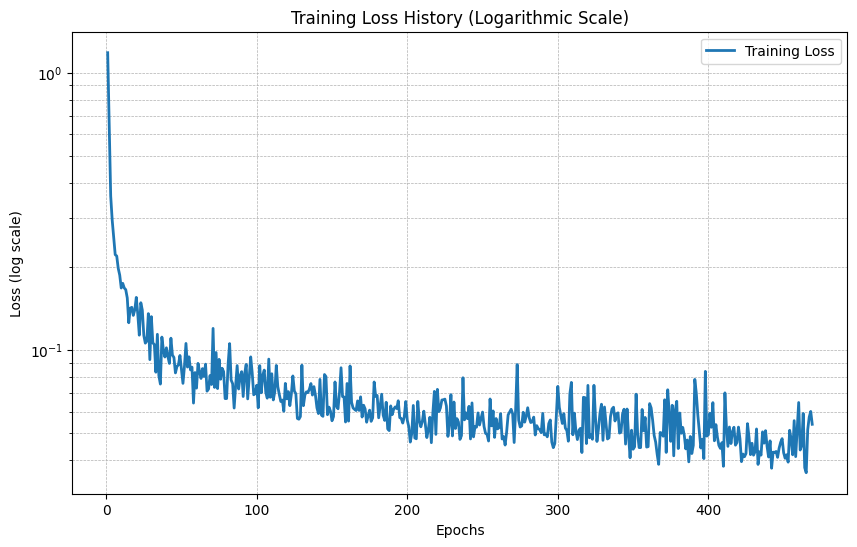

In [ ]:
import matplotlib.pyplot as plt


# Logarithmic plot of the loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, linestyle='-', label='Training Loss', linewidth=2)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.title('Training Loss History (Logarithmic Scale)')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # Grid with less intrusive lines
plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving conditioned_unet_5_epochs.pth to conditioned_unet_5_epochs.pth


In [ ]:
unet = ClassConditionalUNet(in_channels=1, num_classes=10, num_hiddens=64).to('cuda')
unet.load_state_dict(torch.load("conditioned_unet_5_epochs.pth"))

#If working outside of colab, you can load the model weights from a local file:
#unet.load_state_dict(torch.load("Weights/conditioned_unet_5_epochs.pth"))

<All keys matched successfully>

### Implementing a sampler + plotting

In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
@torch.inference_mode()
def ddpm_sample_batch_conditional(
    unet: torch.nn.Module,
    ddpm_schedule: dict,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
    device: torch.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
) -> torch.Tensor:
    unet.eval()
    torch.manual_seed(seed)

    B = c.shape[0]
    img = torch.randn(B, 1, img_wh[0], img_wh[1], device=device)

    alphas     = ddpm_schedule["alphas"].to(device)
    betas      = ddpm_schedule["betas"].to(device)
    alpha_bars = ddpm_schedule["alpha_bars"].to(device)

    c_uncond = torch.zeros_like(c)

    for t in reversed(range(1, num_ts)):
        t_frac = torch.full((B, 1), float(t) / num_ts, device=device)

        eps_uncond = unet(img, c_uncond, t_frac)
        eps_cond   = unet(img, c,       t_frac)

        eps_theta = eps_uncond + guidance_scale * (eps_cond - eps_uncond)

        alpha_bar_t         = alpha_bars[t].view(1,1,1,1)
        alpha_bar_t_minus1  = alpha_bars[t-1].view(1,1,1,1)
        beta_t              = betas[t].view(1,1,1,1)
        alpha_t             = alphas[t].view(1,1,1,1)

        x0_hat = (img - torch.sqrt(1 - alpha_bar_t) * eps_theta) / torch.sqrt(alpha_bar_t)

        noise = torch.randn_like(img) if t > 1 else torch.zeros_like(img)
        img = (
            (torch.sqrt(alpha_bar_t_minus1) * beta_t / (1 - alpha_bar_t)) * x0_hat
            + (torch.sqrt(alpha_t) * (1 - alpha_bar_t_minus1) / (1 - alpha_bar_t)) * img
            + torch.sqrt(beta_t) * noise
        )

    return img


def generate_and_plot_ddpm_samples(
    unet,
    ddpm_schedule,
    img_wh=(28, 28),
    num_ts=300,
    seed=0,
    batch_size=40,
    num_cols=8,
    title="DDPM samples",
    labels=None,
    num_classes=None,
    guidance_scale=5.0,
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
):

    c = F.one_hot(labels.to(device), num_classes=num_classes).float()
    samples = ddpm_sample_batch_conditional(
        unet=unet,
        ddpm_schedule=ddpm_schedule,
        c=c,
        img_wh=img_wh,
        num_ts=num_ts,
        guidance_scale=guidance_scale,
        seed=seed
    )

    # move to CPU, clamp and plot
    samples = samples.cpu().detach().clamp(0, 1)
    num_rows = (batch_size + num_cols - 1) // num_cols
    plt.figure(figsize=(num_cols * 1.5, num_rows * 1.5))

    for i in range(min(batch_size, samples.size(0))):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(samples[i, 0], cmap='gray')
        plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()



### Testing the discriminator without fine-tuning

In [ ]:
beta1 = 0.0001
beta2 = 0.02
num_ts = 300
schedule = ddpm_schedule(beta1, beta2, num_ts)

In [ ]:

labels = torch.arange(10).repeat_interleave(4)
num_classes = 10
c = F.one_hot(labels.to(device), num_classes=num_classes).float()

samples = ddpm_sample_batch_conditional(
    unet=unet,
    ddpm_schedule=schedule,
    c=c,
    img_wh=(28, 28),
    num_ts=300,
    guidance_scale=5,
    seed=1
)


resized_samples = prepare_batch_discr(samples)
mnist = train_dataset
loader = DataLoader(mnist, batch_size=300, shuffle=True)
images, labels = next(iter(loader))
resized_mnist = prepare_batch_discr(images)



In [ ]:
real_imgs = resized_mnist.to(device)
fake_imgs = resized_samples.to(device)

with torch.no_grad():
    real_scores = netD(real_imgs)    # expected to be close to 1
    fake_scores = netD(fake_imgs)    # expected to be close to 0

print(f"Average score for real MNIST: {real_scores.mean().item():.4f}")
print(f"Average score for DDPM samples: {fake_scores.mean().item():.4f}")


Average score for real MNIST: 0.6081
Average score for DDPM samples: 0.1757


### Plotting pre-trained images

In [ ]:
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

unet_class_cond = ClassConditionalUNet(in_channels=1, num_classes=10, num_hiddens=64).to(device)
unet_class_cond.load_state_dict(torch.load("conditioned_unet_5_epochs.pth"))
labels = torch.arange(10).repeat_interleave(4)

betas = (1e-4, 0.02)
num_ts = 300
schedule = ddpm_schedule(betas[0], betas[1], num_ts)


generate_and_plot_ddpm_samples(
    unet=unet_class_cond,
    ddpm_schedule=schedule,
    img_wh=(28, 28),
    num_ts=300,
    seed=0,
    batch_size=40,
    num_cols=10,
    title="DDPM: 4 samples per digit (0-9) with classifier free guidance",
    labels=labels,
    num_classes=10,
    guidance_scale=5.0,
    device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)

generate_and_plot_ddpm_samples(
    unet=unet_class_cond,
    ddpm_schedule=schedule,
    img_wh=(28, 28),
    num_ts=300,
    seed=0,
    batch_size=40,
    num_cols=10,
    title="DDPM: 4 samples per digit (0-9) without classifier free guidance",
    labels=labels,
    num_classes=10,
    guidance_scale=0.0,
    device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)


NameError: name 'torch' is not defined

### Fine-tuning diffusion model and training discriminator from scratch on noise


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

beta_start = 1e-4
beta_end   = 0.02
num_timesteps = 300
batch_size    = 128
epochs        = 20
lr_d          = 1e-4
lr_g          = 1e-5
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

schedule = ddpm_schedule(beta_start, beta_end, num_timesteps)

unet_ft_class_cond = ClassConditionalUNet(in_channels=1, num_classes=10, num_hiddens=64).to(device)
unet_ft_class_cond.load_state_dict(torch.load("conditioned_unet_5_epochs.pth"))
discriminator = Discriminator(ngpu=1, nc=2, ndf=64).to(device)
discriminator.apply(weights_init)

optD = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
optG = optim.Adam(unet_ft_class_cond.parameters(), lr=lr_g, betas=(0.5, 0.999))
bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()

mnist = MNIST(root="./data", train=True, download=True, transform=ToTensor())
dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True, num_workers=4)
num_classes=10
p_uncond = 0.1

for epoch in range(epochs):
    i = 0
    for imgs, labels in dataloader:
        imgs = imgs.to(device)

        t = torch.randint(0, num_timesteps, (imgs.size(0),), device=device)
        alpha_bar_t = schedule['alpha_bars'].to(device)[t].view(-1,1,1,1)
        sqrt_ab = torch.sqrt(alpha_bar_t)
        sqrt_1_ab = torch.sqrt(1 - alpha_bar_t)

        noise = torch.randn_like(imgs)
        x_t = sqrt_ab * imgs + sqrt_1_ab * noise

        t_norm = (t.float() / num_timesteps).view(-1,1).to(device)

        for p in unet_ft_class_cond.parameters():        p.requires_grad_(False)
        for p in discriminator.parameters(): p.requires_grad_(True)
        discriminator.train()
        unet_ft_class_cond.train()
        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=num_classes).float().to(device)
        #Zeros the one_hot_labels every 1/p_uncond on average.
        dropout_mask = (torch.rand(one_hot_labels.size(0), device=device) > p_uncond).float().unsqueeze(1)
        one_hot_labels = one_hot_labels * dropout_mask

        eps_pred = unet_ft_class_cond(x_t,one_hot_labels, t_norm)

        fake_D_input = torch.cat([x_t, eps_pred], dim=1)
        real_D_input = torch.cat([x_t, noise], dim=1)

        real_D_input = real_D_input.detach()
        fake_D_input = fake_D_input.detach()

        real_scores = discriminator(real_D_input)
        fake_scores = discriminator(fake_D_input)
        labels_real = torch.ones_like(real_scores)
        labels_fake = torch.zeros_like(fake_scores)

        lossD = bce_loss(real_scores, labels_real) + bce_loss(fake_scores, labels_fake)
        optD.zero_grad()
        lossD.backward()
        optD.step()
        if i % 10 == 0:
          print(f"real scores: {real_scores.mean().item():.4f}, fake scores: {fake_scores.mean().item():.4f}")

        if epoch > 0:
          for p in unet_ft_class_cond.parameters():        p.requires_grad_(True)
          for p in discriminator.parameters(): p.requires_grad_(False)
          unet_ft_class_cond.train()
          discriminator.train()

          eps_pred = unet_ft_class_cond(x_t, one_hot_labels, t_norm)
          fake_d_input = torch.cat([x_t, eps_pred], dim=1)

          gen_scores = discriminator(fake_d_input)
          labels_real = torch.ones_like(gen_scores)

          lossG = bce_loss(gen_scores, labels_real)
          optG.zero_grad()
          lossG.backward()
          optG.step()
          if i % 10 == 0:
            print(f"Fake scores from generator after disc update: {gen_scores.mean().item():.4f}")
          del imgs, t, alpha_bar_t, sqrt_ab, sqrt_1_ab, noise, x_t, t_norm, eps_pred, real_D_input, fake_D_input, real_scores, fake_scores, labels_real, labels_fake, gen_scores
        else:
          del imgs, t, alpha_bar_t, sqrt_ab, sqrt_1_ab, noise, x_t, t_norm, real_D_input, fake_D_input, real_scores, fake_scores, labels_fake
        i += 1



real scores: 0.4215, fake scores: 0.4240
real scores: 0.5049, fake scores: 0.5043
real scores: 0.4915, fake scores: 0.4771
real scores: 0.4930, fake scores: 0.4824
real scores: 0.5057, fake scores: 0.4887
real scores: 0.5014, fake scores: 0.4703
real scores: 0.5278, fake scores: 0.4942
real scores: 0.5208, fake scores: 0.4739
real scores: 0.5650, fake scores: 0.5131
real scores: 0.5115, fake scores: 0.4343
real scores: 0.5440, fake scores: 0.4721
real scores: 0.5440, fake scores: 0.4606
real scores: 0.5423, fake scores: 0.4372
real scores: 0.5971, fake scores: 0.4518
real scores: 0.5551, fake scores: 0.4162
real scores: 0.6681, fake scores: 0.4911
real scores: 0.4636, fake scores: 0.2748
real scores: 0.6822, fake scores: 0.4474
real scores: 0.6139, fake scores: 0.3390
real scores: 0.6019, fake scores: 0.2924
real scores: 0.8009, fake scores: 0.4711
real scores: 0.6254, fake scores: 0.3061
real scores: 0.7428, fake scores: 0.4259
real scores: 0.7453, fake scores: 0.3715
real scores: 0.6

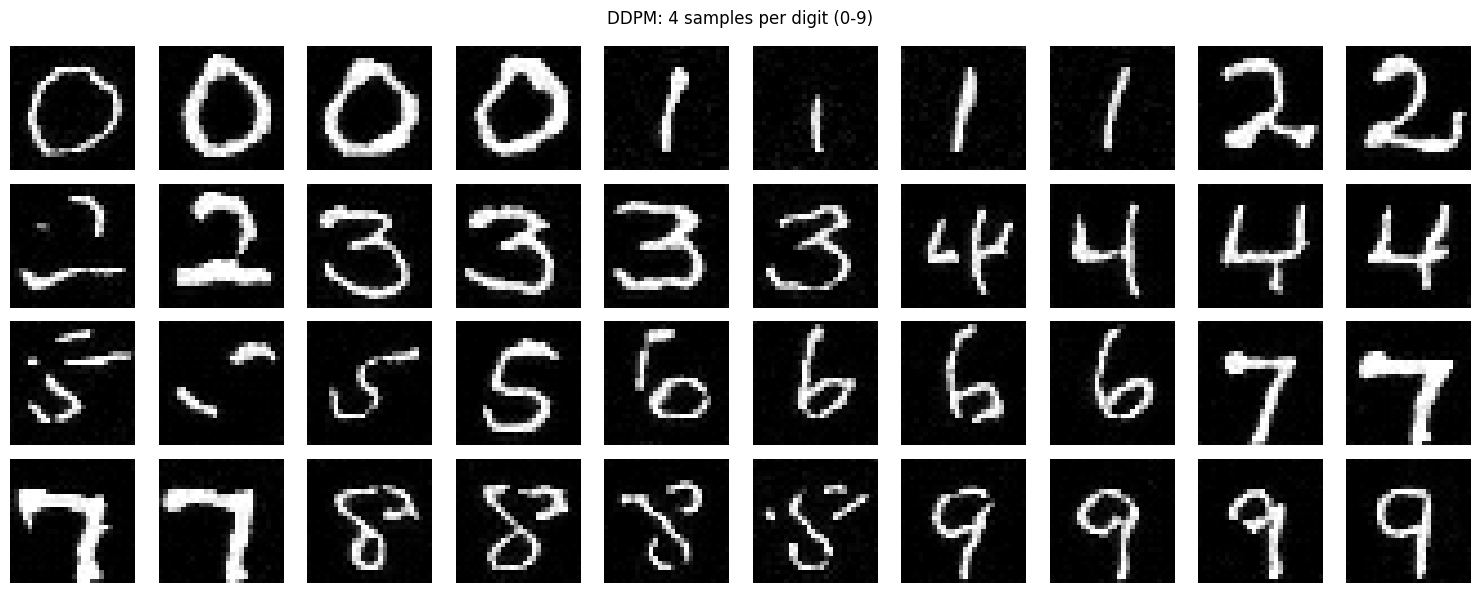

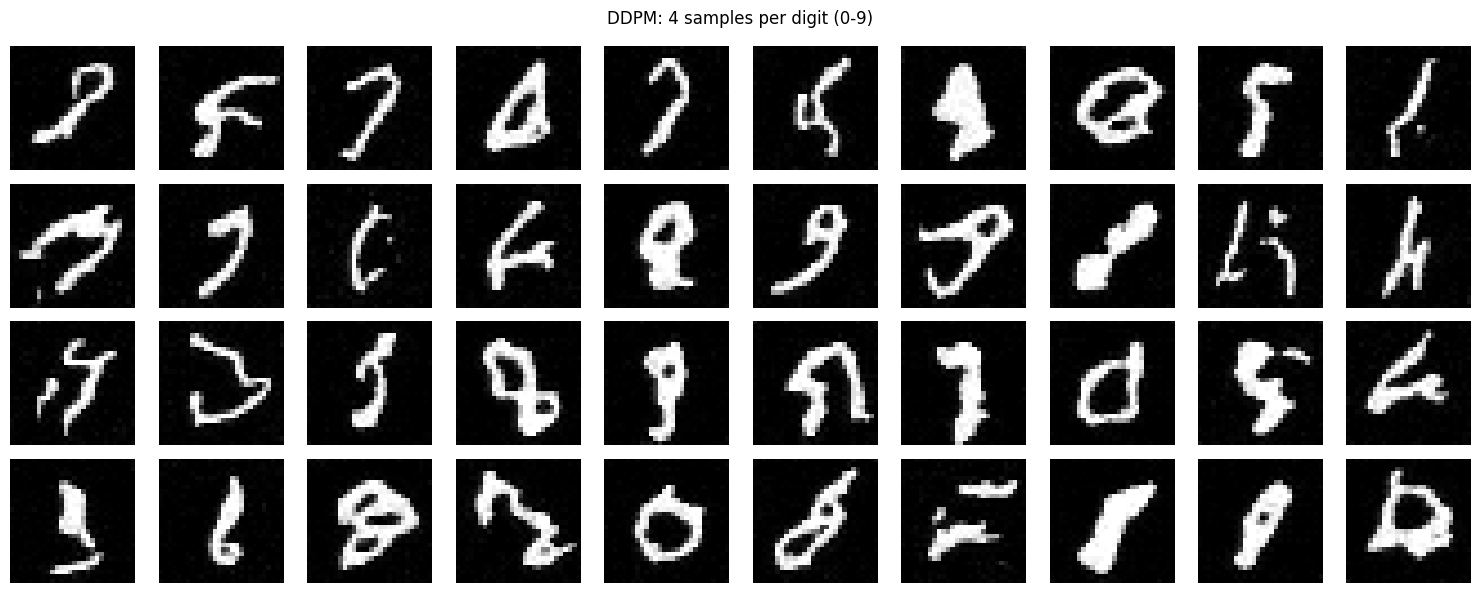

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

labels = torch.arange(10).repeat_interleave(4)

betas = (1e-4, 0.02)
num_ts = 300
schedule = ddpm_schedule(betas[0], betas[1], num_ts)


generate_and_plot_ddpm_samples(
    unet=unet_ft_class_cond,
    ddpm_schedule=schedule,
    img_wh=(28, 28),
    num_ts=300,
    seed=0,
    batch_size=40,
    num_cols=10,
    title="DDPM: 4 samples per digit (0-9)",
    labels=labels,
    num_classes=10,
    guidance_scale=5.0,
    device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)

generate_and_plot_ddpm_samples(
    unet=unet_ft_class_cond,
    ddpm_schedule=schedule,
    img_wh=(28, 28),
    num_ts=300,
    seed=0,
    batch_size=40,
    num_cols=10,
    title="DDPM: 4 samples per digit (0-9)",
    labels=labels,
    num_classes=10,
    guidance_scale=0.0,
    device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)


In [ ]:
# Testing the images on the pre-trained discriminator
labels = torch.arange(10).repeat_interleave(10)
num_classes = 10
c = F.one_hot(labels.to(device), num_classes=num_classes).float()
samples = ddpm_sample_batch_conditional(
    unet=unet_ft_class_cond,
    ddpm_schedule=schedule,
    c=c,
    img_wh=(28, 28),
    num_ts=300,
    guidance_scale=5,
    seed=1
)


resized_samples = prepare_batch_discr(samples)
mnist = train_dataset
loader = DataLoader(mnist, batch_size=300, shuffle=True)
images, labels = next(iter(loader))
resized_mnist = prepare_batch_discr(images)

real_imgs = resized_mnist.to(device)
fake_imgs = resized_samples.to(device)

with torch.no_grad():
    real_scores = netD(real_imgs)    # expected to be close to 1
    fake_scores = netD(fake_imgs)    # expected to be close to 0

print(f"Average score for real MNIST: {real_scores.mean().item():.4f}")
print(f"Average score for DDPM samples: {fake_scores.mean().item():.4f}")


Average score for real MNIST: 0.6081
Average score for DDPM samples: 0.1335


In [ ]:
torch.save(unet.state_dict(), "cond_unet_ft_noise_20.pth")
from google.colab import files
files.download("cond_unet_ft_noise_20.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Fine-tuning diffusion model and training discriminator from scratch on noise, add time as input to discriminator

In [ ]:
import torch
import torch.nn as nn
import urllib.request

# --- Define the architecture ---
class DiscriminatorTime(nn.Module):
    def __init__(self, ngpu, nc=1, ndf=64):
        super(DiscriminatorTime, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc+1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x, t):
        B, _, H, W = x.shape
        t = t.view(B, 1, 1, 1).expand(B, 1, H, W)
        xt = torch.cat([x, t], dim=1)
        return self.main(xt).view(-1)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

beta_start = 1e-4
beta_end   = 0.02
num_timesteps = 300
batch_size    = 128
epochs        = 5
lr_d          = 1e-4
lr_g          = 1e-5
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

schedule = ddpm_schedule(beta_start, beta_end, num_timesteps)

unet_ft_class_cond = ClassConditionalUNet(in_channels=1, num_classes=10, num_hiddens=64).to(device)
unet_ft_class_cond.load_state_dict(torch.load("conditioned_unet_5_epochs.pth"))
discriminator = DiscriminatorTime(ngpu=1, nc=2, ndf=64).to(device)
discriminator.apply(weights_init)

optD = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
optG = optim.Adam(unet_ft_class_cond.parameters(), lr=lr_g, betas=(0.5, 0.999))
bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()

mnist = MNIST(root="./data", train=True, download=True, transform=ToTensor())
dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True, num_workers=4)
num_classes=10
p_uncond = 0.1

for epoch in range(epochs):
    i = 0
    for imgs, labels in dataloader:
        imgs = imgs.to(device)

        t = torch.randint(0, num_timesteps, (imgs.size(0),), device=device)
        alpha_bar_t = schedule['alpha_bars'].to(device)[t].view(-1,1,1,1)
        sqrt_ab = torch.sqrt(alpha_bar_t)
        sqrt_1_ab = torch.sqrt(1 - alpha_bar_t)

        noise = torch.randn_like(imgs)
        x_t = sqrt_ab * imgs + sqrt_1_ab * noise

        t_norm = (t.float() / num_timesteps).view(-1,1).to(device)

        for p in unet_ft_class_cond.parameters():        p.requires_grad_(False)
        for p in discriminator.parameters(): p.requires_grad_(True)
        discriminator.train()
        unet_ft_class_cond.train()
        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=num_classes).float().to(device)
        #Zeros the one_hot_labels every 1/p_uncond on average.
        dropout_mask = (torch.rand(one_hot_labels.size(0), device=device) > p_uncond).float().unsqueeze(1)
        one_hot_labels = one_hot_labels * dropout_mask

        eps_pred = unet_ft_class_cond(x_t,one_hot_labels, t_norm)

        fake_D_input = torch.cat([x_t, eps_pred], dim=1)
        real_D_input = torch.cat([x_t, noise], dim=1)

        real_D_input = real_D_input.detach()
        fake_D_input = fake_D_input.detach()

        real_scores = discriminator(real_D_input, t_norm)
        fake_scores = discriminator(fake_D_input, t_norm)
        labels_real = torch.ones_like(real_scores)
        labels_fake = torch.zeros_like(fake_scores)

        lossD = bce_loss(real_scores, labels_real) + bce_loss(fake_scores, labels_fake)
        optD.zero_grad()
        lossD.backward()
        optD.step()
        if i % 10 == 0:
          print(f"real scores: {real_scores.mean().item():.4f}, fake scores: {fake_scores.mean().item():.4f}")

        if epoch > 0:
          for p in unet_ft_class_cond.parameters():        p.requires_grad_(True)
          for p in discriminator.parameters(): p.requires_grad_(False)
          unet_ft_class_cond.train()
          discriminator.train()

          eps_pred = unet_ft_class_cond(x_t, one_hot_labels, t_norm)
          fake_d_input = torch.cat([x_t, eps_pred], dim=1)

          gen_scores = discriminator(fake_d_input, t_norm)
          labels_real = torch.ones_like(gen_scores)

          lossG = bce_loss(gen_scores, labels_real)
          optG.zero_grad()
          lossG.backward()
          optG.step()
          if i % 10 == 0:
            print(f"Fake scores from generator after disc update: {gen_scores.mean().item():.4f}")
          del imgs, t, alpha_bar_t, sqrt_ab, sqrt_1_ab, noise, x_t, t_norm, eps_pred, real_D_input, fake_D_input, real_scores, fake_scores, labels_real, labels_fake, gen_scores
        else:
          del imgs, t, alpha_bar_t, sqrt_ab, sqrt_1_ab, noise, x_t, t_norm, real_D_input, fake_D_input, real_scores, fake_scores, labels_fake
        i += 1



real scores: 0.4372, fake scores: 0.4401
real scores: 0.5096, fake scores: 0.5079
real scores: 0.4947, fake scores: 0.4824
real scores: 0.4817, fake scores: 0.4628
real scores: 0.5244, fake scores: 0.5036
real scores: 0.5340, fake scores: 0.5006
real scores: 0.4644, fake scores: 0.4367
real scores: 0.5237, fake scores: 0.4693
real scores: 0.5987, fake scores: 0.5416
real scores: 0.5467, fake scores: 0.4471
real scores: 0.4909, fake scores: 0.4092
real scores: 0.5746, fake scores: 0.4830
real scores: 0.6134, fake scores: 0.4623
real scores: 0.5978, fake scores: 0.4203
real scores: 0.6994, fake scores: 0.4582
real scores: 0.6423, fake scores: 0.3900
real scores: 0.6738, fake scores: 0.3950
real scores: 0.7890, fake scores: 0.4658
real scores: 0.8039, fake scores: 0.4466
real scores: 0.7650, fake scores: 0.3358
real scores: 0.7574, fake scores: 0.2508
real scores: 0.7093, fake scores: 0.3005
real scores: 0.6017, fake scores: 0.2298
real scores: 0.8359, fake scores: 0.4141
real scores: 0.7

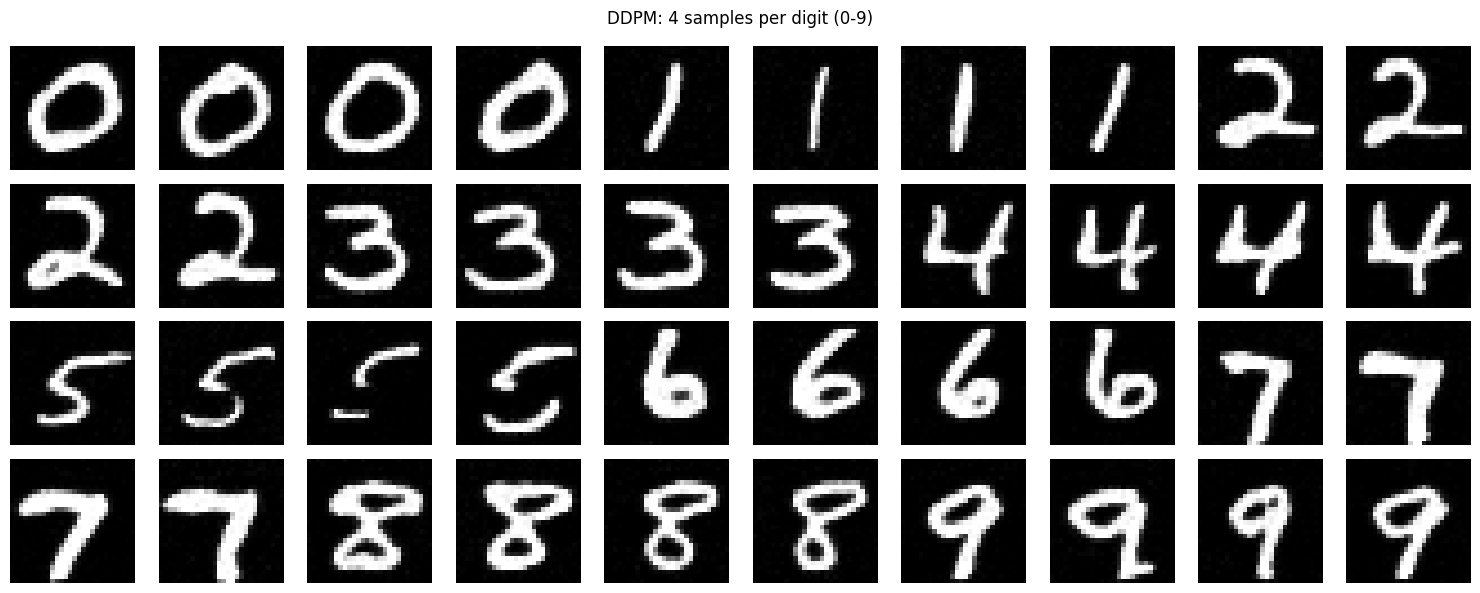

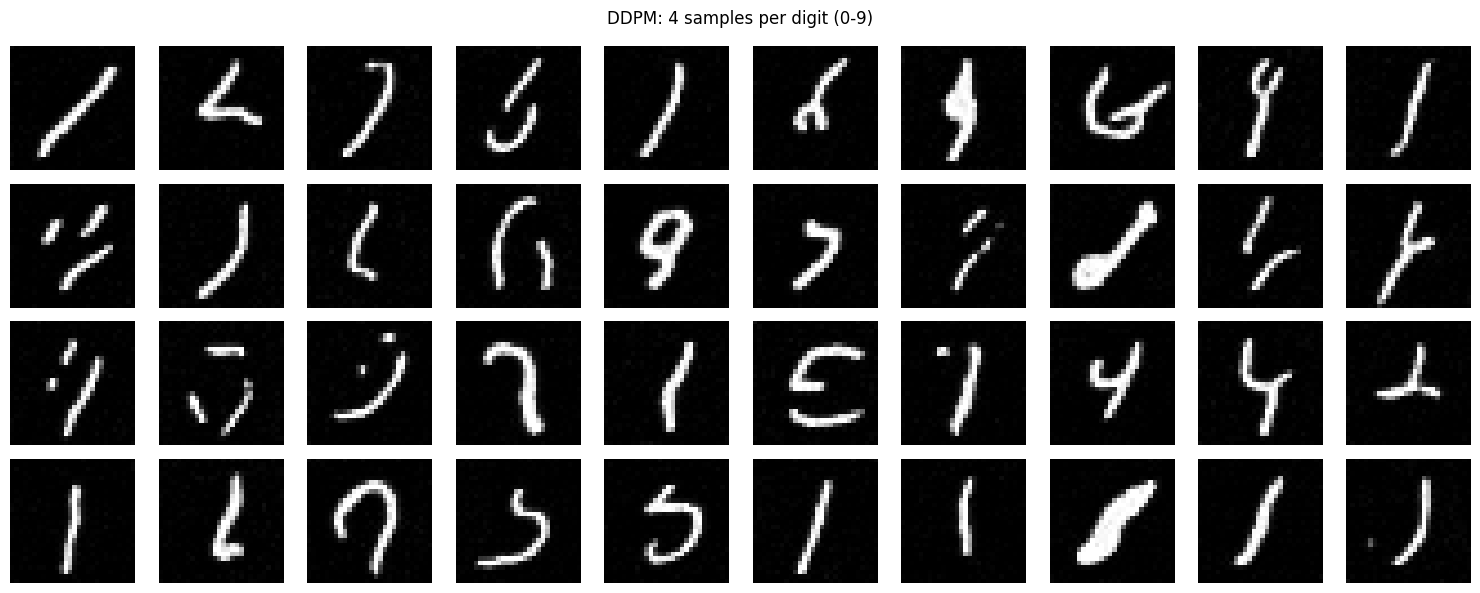

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

labels = torch.arange(10).repeat_interleave(4)

betas = (1e-4, 0.02)
num_ts = 300
schedule = ddpm_schedule(betas[0], betas[1], num_ts)


generate_and_plot_ddpm_samples(
    unet=unet_ft_class_cond,
    ddpm_schedule=schedule,
    img_wh=(28, 28),
    num_ts=300,
    seed=0,
    batch_size=40,
    num_cols=10,
    title="DDPM: 4 samples per digit (0-9)",
    labels=labels,
    num_classes=10,
    guidance_scale=5.0,
    device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)

generate_and_plot_ddpm_samples(
    unet=unet_ft_class_cond,
    ddpm_schedule=schedule,
    img_wh=(28, 28),
    num_ts=300,
    seed=0,
    batch_size=40,
    num_cols=10,
    title="DDPM: 4 samples per digit (0-9)",
    labels=labels,
    num_classes=10,
    guidance_scale=0.0,
    device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)


In [ ]:
# Testing the images on the pre-trained discriminator
labels = torch.arange(10).repeat_interleave(10)
num_classes = 10
c = F.one_hot(labels.to(device), num_classes=num_classes).float()
samples = ddpm_sample_batch_conditional(
    unet=unet_ft_class_cond,
    ddpm_schedule=schedule,
    c=c,
    img_wh=(28, 28),
    num_ts=300,
    guidance_scale=5,
    seed=1
)


resized_samples = prepare_batch_discr(samples)
mnist = train_dataset
loader = DataLoader(mnist, batch_size=300, shuffle=True)
images, labels = next(iter(loader))
resized_mnist = prepare_batch_discr(images)

real_imgs = resized_mnist.to(device)
fake_imgs = resized_samples.to(device)

with torch.no_grad():
    real_scores = netD(real_imgs)    # expected to be close to 1
    fake_scores = netD(fake_imgs)    # expected to be close to 0

print(f"Average score for real MNIST: {real_scores.mean().item():.4f}")
print(f"Average score for DDPM samples: {fake_scores.mean().item():.4f}")


Average score for real MNIST: 0.6081
Average score for DDPM samples: 0.1873


In [ ]:
torch.save(unet.state_dict(), "cond_unet_ft_noise_discr_time_5.pth")
from google.colab import files
files.download("cond_unet_ft_noise_discr_time_5.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>